# Factorial Kriging Analysis

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

flagInternetAvailable = True ## Set to false if no internet

The Grid containing the information is downloaded from the distribution.

The loaded file (called **grid **) contains 3 variables:

- **P** (phosphorus) which is the *variable of interest*
- **Cr** (chromium) is an auxiliary variable
- **Ni** (nickel) another auxiliary variable


In [ ]:
fileImage='Image.ascii'
if flagInternetAvailable:
    fileNF, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/FKA/'+fileImage,'./'+fileImage)
else:
    fileNF='./'+fileImage

grid = gl.DbGrid.createFromNF(fileNF)
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)

In [ ]:
dbfmt = gl.DbStringFormat()
dbfmt.setFlags(flag_resume=False,flag_vars=False,flag_stats=True, names="P")
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Statistics
--------------------
6 - Name P - Locator NA
 Nb of data          =     262144
 Nb of active values =     242306
 Minimum value       =      0.000
 Maximum value       =    314.000
 Mean value          =     31.767
 Standard Deviation  =     21.759
 Variance            =    473.457
 

Note that some pixels are not informed for variable **P**.

Statistics on auxiliary variables

In [ ]:
dbfmt.setFlags(flag_vars=False, flag_resume=True, flag_stats=True, names=["Cr", "Ni"])
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Maximum Number of UIDs       = 6
Total number of samples      = 262144

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        512       512

Data Base Statistics
--------------------
4 - Name Cr - Locator NA
 Nb of data          =     262144
 Nb of active values =     262144
 Minimum value       =   2591.000
 Maximum value       =  24982.000
 Mean value          =  16800.231
 Standard Deviation  =    936.213
 Variance            = 876495.558
5 - Name Ni - Locator NA
 Nb of data          =     262144
 Nb of active values =     262144
 Minimum value       =   1840.000
 Maximum value       =  12593.000
 Mean value          =  10111.444
 Standard Deviation  =    884.996
 Variance            = 783217.898
 

Correlation between variables

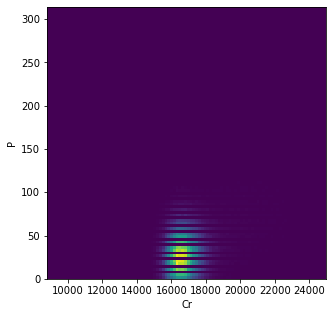

In [ ]:
ax = gp.correlation(grid, namex="Cr", namey="P", bins=100)

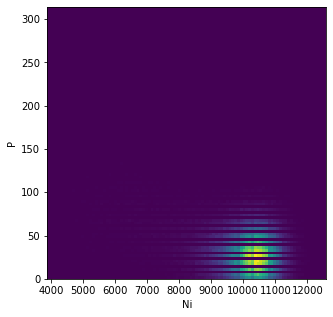

In [ ]:
ax = gp.correlation(grid, namex="Ni", namey="P", bins=100)

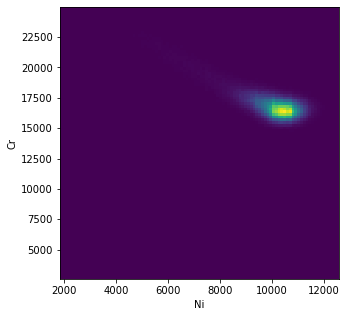

In [ ]:
ax = gp.correlation(grid, namex="Ni", namey="Cr", bins=100)

Using inverse square distance for completing the variable **P**

In [ ]:
grid.setLocator("P", gl.ELoc.Z)
err = gl.db_grid_fill(grid)

We concentrate on the variable of interest **P** completed (**Fill.P**) in the next operations

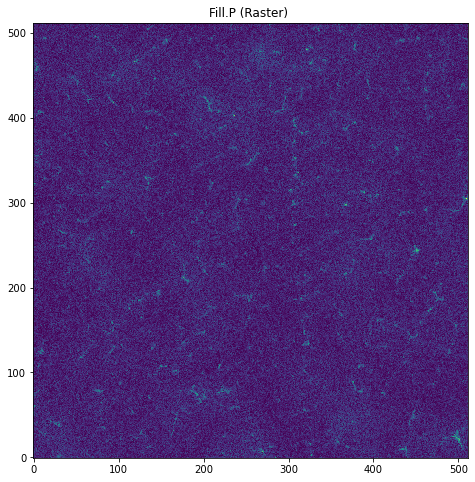

In [ ]:
gp.setDefaultGeographic(dims=[8,8])
ax = grid.plot("Fill.P")

Variogram Calculation along Grid main axes

In [11]:
varioparam = gl.VarioParam.createMultipleFromGrid(grid, npas=100)
varioP = gl.Vario(varioparam, grid)
err = varioP.compute()
modelP = gl.Model()
err = modelP.fit(varioP, types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.POWER],
                 optvar=gl.Option_VarioFit(True, False))

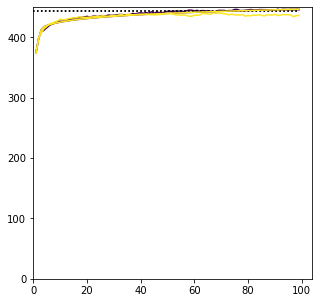

In [12]:
ax = gp.varmod(varioP, modelP)

We must define the **Neighborhood**

In [13]:
neigh = gl.NeighImage([10,10])

The **image** neighborhood is based on $(2*10+1)^2=441$ pixels (centered on the target pixel).

During the estimation, only the contribution of second and third basic structures are kept (Nugget Effect is filtered out): ** Factorial Kriging Analysis**.

In [14]:
modelP.setCovaFiltered(0, True)
means = gl.dbStatisticsMono(grid,["Fill.P"],[gl.EStatOption.MEAN])
modelP.setMeans(means)
modelP


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 3
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =    273.080
  (This component is Filtered)
Spherical
- Sill         =     56.089
- Range        =      3.600
Power (Third Parameter = 0.0879341)
- Slope        =      1.187


In [15]:
err  = gl.krimage(grid,modelP,neigh,namconv=gl.NamingConvention("Mono"))

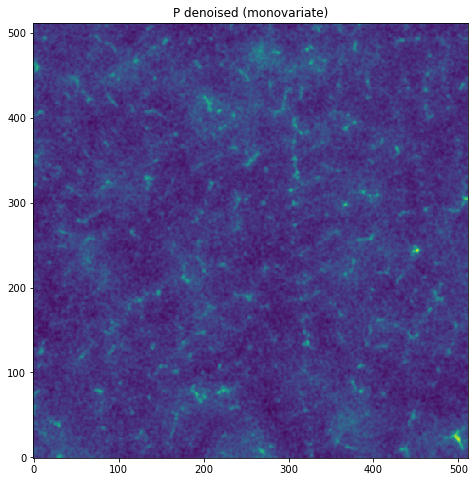

In [16]:
ax = grid.plot("Mono*.P")
ax.decoration(title="P denoised (monovariate)")

Correlation for **P** variable between Initial image (completed) and its Filtered version (monovariate FKA)

In [17]:
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 8
Maximum Number of UIDs       = 8
Total number of samples      = 262144

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        512       512

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Cr - Locator = NA
Column = 4 - Name = Ni - Locator = NA
Column = 5 - Name = P - Locator = NA
Column = 6 - Name = Fill.P - Locator = NA
Column = 7 - Name = Mono.Fill.P - Locator = z1

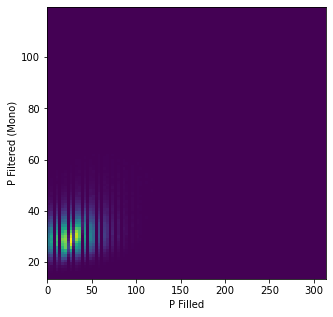

In [18]:
ax = gp.correlation(grid, namex="Fill.P", namey="Mono.Fill.P", bins=100)
ax.decoration(xlabel="P Filled",ylabel="P Filtered (Mono)")

## Multivariate approach

In [ ]:
grid.setLocators(["Fill.P", "Cr", "Ni"], gl.ELoc.Z)

varioM = gl.Vario(varioparam, grid)
err = varioM.compute()
modelM = gl.Model()
err = modelM.fit(varioM, types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.POWER],
                 optvar=gl.Option_VarioFit(True, False))

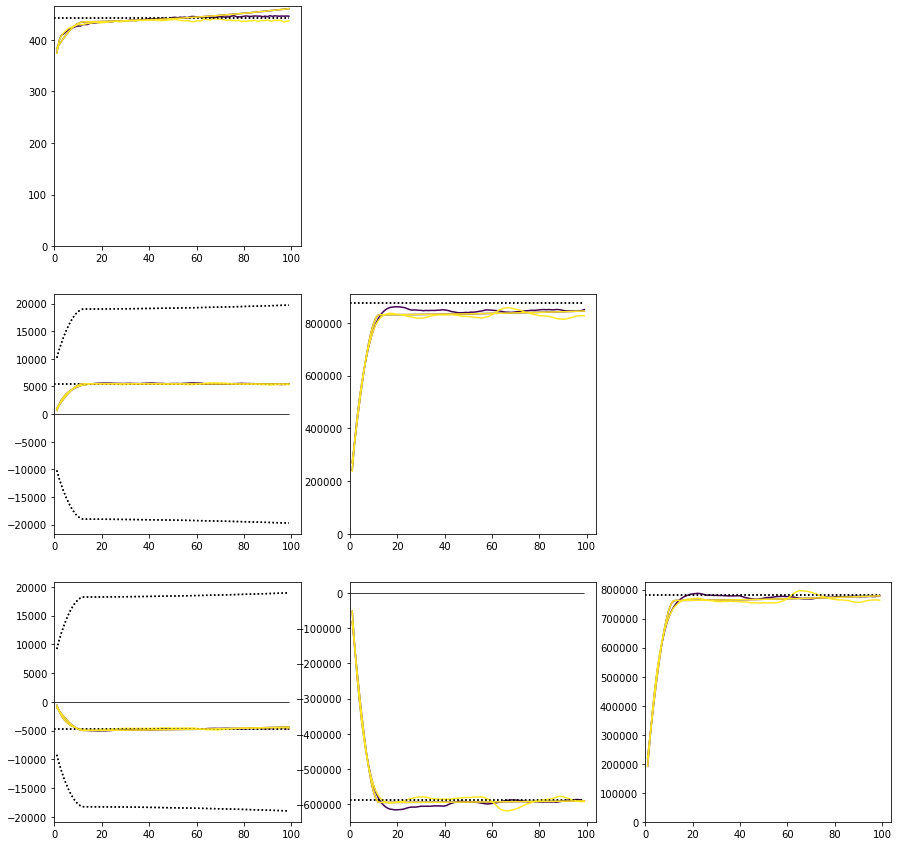

In [ ]:
ax = gp.varmod(varioM, modelM)

Printing the contents of the fitted Multivariate Mpdel

In [ ]:
modelM.setCovaFiltered(0, True)
means = gl.dbStatisticsMono(grid,["Fill.P", "Cr", "Ni"],[gl.EStatOption.MEAN])
modelM.setMeans(means)
modelM


Model characteristics
Space dimension              = 2
Number of variable(s)        = 3
Number of basic structure(s) = 3
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]   376.850   452.534  -476.811
     [  1,]   452.534194188.109-11524.845
     [  2,]  -476.811-11524.845145939.572
  (This component is Filtered)
Spherical
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]    57.513  5031.290 -4489.149
     [  1,]  5031.290636076.559-583291.704
     [  2,] -4489.149-583291.704616673.997
- Range        =     12.375
Power (Third Parameter = 1.99)
- Slope matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]     0.263    -0.414     6.133
     [  1,]    -0.414   145.976    44.478
     [  2,]     6.133    44.478   163.446


Multivariable Factorial Kriging Analysis

In [ ]:
err  = gl.krimage(grid,modelM,neigh,namconv=gl.NamingConvention("Multi"))

Note that, using the same **neigh** as in monovariate, the dimension of the Kriging System is now $3 * 441 = 1323$

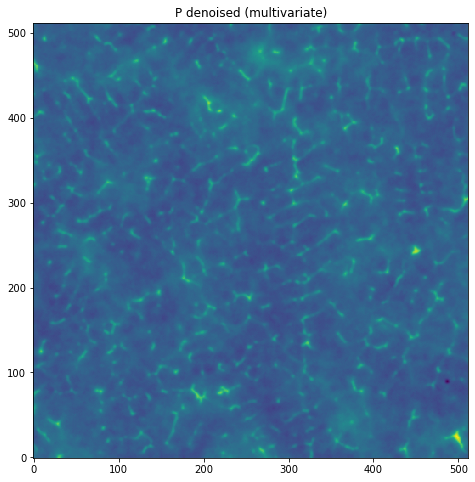

In [ ]:
ax = grid.plot("Multi*.P")
ax.decoration(title="P denoised (multivariate)")

Correlation for **P** variable between Initial image and its Filtered version (multivariate FKA)

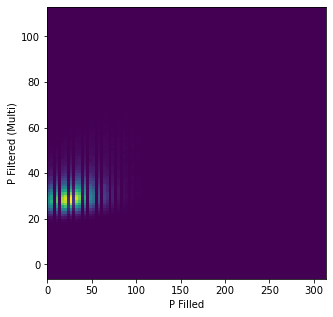

In [ ]:
ax = gp.correlation(grid, namex="Fill.P", namey="Multi.Fill.P", bins=100)
ax.decoration(xlabel="P Filled",ylabel="P Filtered (Multi)")

Correlation for **P** filtered variable between he Monovariate and the Multivariate case

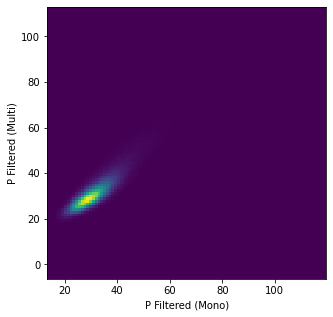

In [ ]:
ax = gp.correlation(grid, namex="Mono.Fill.P", namey="Multi.Fill.P", bins=100)
ax.decoration(xlabel="P Filtered (Mono)",ylabel="P Filtered (Multi)")